In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import os,re
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from scipy.stats import ks_2samp
from scipy.stats import kruskal
%matplotlib inline

In [20]:
####################################################################
# df = pd.read_csv("master.tsv",sep="\t",index_col=0)
# panelName = "allTPmerged"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/tp50_416bOnly_valuesWithProperties",sep="\t",index_col=0)
# panelName = "TP50_416bOnly"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/tp50_bothBeads_valuesWithProperties",sep="\t",index_col=0)
# panelName = "TP50_BothBeads"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/tp3ValuesWithProperties.tsv",sep="\t",index_col=0)
# panelName = "TP3"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/tp4ValuesWithProperties.tsv",sep="\t",index_col=0)
# panelName = "TP4"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/tp5ValuesWithProperties.tsv",sep="\t",index_col=0)
# panelName = "TP5"
# df = pd.read_csv("amlValuesWithProperties.tsv",sep="\t",index_col=0)
# panelName = "AML_MBM"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/tp1ValuesWithProperties.tsv",sep="\t",index_col=0)
# panelName = "tp1"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/mergedFiles/blue/everythingMerged.tsv",sep="\t",index_col=0)
# panelName = "blue"
df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/mergedFiles/purple/everythingMerged.tsv",sep="\t",index_col=0)
panelName = "purple"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/mergedFiles/orange/everythingMerged.tsv",sep="\t",index_col=0)
# panelName = "orange"
# df = pd.read_csv("myeValuesWithProperties.tsv",sep="\t",index_col=0)
# panelName = "MYE"
# df = pd.read_csv("/Users/saurabhgulati/v2DataAnalysis/cllValuesWithProperties.tsv",sep="\t")
# panelName = "CLL"
####################################################################
# y = df['NormalizedMean']
# x = df.drop(columns=['NormalizedMean','fwd_hairpin_dG','amplicon_seq',
#  'fwd_hairpin_tm','fwd_homod_dG',
#  'fwd_homod_tm','rev_hairpin_dG',
#  'rev_hairpin_tm','fwd_chr_cor',
#  'rev_homod_dG','fwd_primerseq',
#  'rev_homod_tm','pp_heterd_Tm',
# 'rev_chr_cor','rev_primerseq',
#  'pp_heterd_dG','rev_pscore','fwd_pscore',
#  'amplicon_name', 'fwd_distance3p',
#  'rev_distance3p',
#  'amplicon_chr_cor','fwd_maxNrun',
#  'amplicon_chr','rev_maxNrun',
#  'amplicon_start',
#  'amplicon_end',
#  'insert_start',
#  'insert_end','fwd_exact_snp','fwd_range_snp','rev_exact_snp','rev_range_snp',
#  'insert_hit_less2mismatch','Tm_difference','amp_Tm'])

something = df.copy()
temp = something['NormalizedMean']
temp = temp.astype("str")
for i in range(len(temp)):
    if something['NormalizedMean'][i] < 0.2:
        temp[i] = "low"
    elif something['NormalizedMean'][i] >=0.2 and something['NormalizedMean'][i] < 2:
        temp[i] = "ok"
    else:
        temp[i] = "high"
something['classes'] = temp
try :
    something = something.drop(columns=['NormalizedMean','fwd_chr_cor','fwd_primerseq','fwd_maxNrun',
                                       'rev_chr_cor','rev_primerseq','rev_maxNrun',
                                       'amplicon_chr_cor','amplicon_chr','amplicon_seq',
                                       'insert_start','insert_end','amplicon_end','amplicon_start'])
except:
    something = something.drop(columns=['NormalizedMean'])

# try:
#     something = something.drop(columns=['ampliconID'])

renamer = {'fwd_GC_perc':'fwd_GC',
'rev_GC_perc':'rev_GC',
'amplicon_len':'amplicon_length',
'fwd_length':'fwd_len',
'rev_length':'rev_len',
'fwd_primer_maxN':'fwd_maxN',
'rev_primer_maxN':'rev_maxN',
'amp_GC':'ampliconGC'}

something = something.rename(index=str,columns=renamer)
something = something[something['fwd_num_total_hits']<10]    
headers = []
headers.append("feature")
headers.append("\t".join(something['rev_len'][something['classes'] == 'high'].describe().index))
headers.append("\t".join(something['rev_len'][something['classes'] == 'ok'].describe().index))
headers.append("\t".join(something['rev_len'][something['classes'] == 'low'].describe().index))
headers.append("okHigh_ks\tokLow_ks\tlowHigh_ks\tokHigh_kw\tokLow_kw\tlowHigh_kw")
classes = ['high','ok','low']
data = []
data.append('\t'.join(headers))
for i in list(something):
    if i == 'classes':
        continue
    else:

        line = []
        line.append(i)
        for j in classes:
            line.append("\t".join(something[i][something['classes']==j].describe().astype('str')))
        ok = something[i][something['classes']=='ok']
        high = something[i][something['classes']=='high']
        low = something[i][something['classes']=='low']
        okHigh = ks_2samp(ok,high)
        okLow = ks_2samp(ok,low)
        highLow = ks_2samp(low,high)
        try:
            oh = kruskal(ok,high)[1]
        except:
            oh = 'na'
        try:
            ol = kruskal(ok,low)[1]
        except:
            ol = 'na'
        try:
            hl = kruskal(high,low)[1]
        except:
            hl = 'na'
        line.append(str(okHigh[1]))
        line.append(str(okLow[1]))
        line.append(str(highLow[1]))
        line.append(str(oh))
        line.append(str(ol))
        line.append(str(hl))
        data.append("\t".join(line))
with open("/Users/saurabhgulati/v2DataAnalysis/featureBoxes/" + panelName + "boxMetrics.tsv",'w') as OUTPUT:
    OUTPUT.write("\n".join(data))

In [21]:
something = something.sort_values(by=['classes'],ascending=False)  

for i in list(something):
    if i == 'classes':
        continue
    else:
        print(i)
        import matplotlib.pylab as pylab
        params = {'legend.fontsize': 'x-large',
                  'figure.figsize': (15, 5),
                 'axes.labelsize': 'x-large',
                 'axes.titlesize':'x-large',
                 'xtick.labelsize':'x-large',
                 'ytick.labelsize':'x-large'}
        pylab.rcParams.update(params)
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.set(style="whitegrid")
        sns.boxplot(x=i,y='classes',hue='classes',data=something, showmeans=True,palette="RdBu",meanprops=dict(markerfacecolor='black', marker='s',markeredgecolor="black"))
        ax.legend(loc='right')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        ax.set_ylabel("Amplicon Performance")
        ax.set_xlabel(i)
        plt.savefig("/Users/saurabhgulati/v2DataAnalysis/featureBoxes/"+panelName+"_"+i+"_boxplot.png")
        plt.clf()

amp_MaxHomopolymer
ampliconGC
amplicon_length
fwd_GC
fwd_Tm
fwd_len
fwd_maxN
fwd_num_hits_no_mismatch_in_last10
fwd_num_hits_no_mismatch_in_last5
fwd_num_total_hits
rev_GC
rev_Tm
rev_len
rev_maxN
rev_num_hits_no_mismatch_in_last10
rev_num_hits_no_mismatch_in_last5
rev_num_total_hits


<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

<Figure size 842.4x595.44 with 0 Axes>

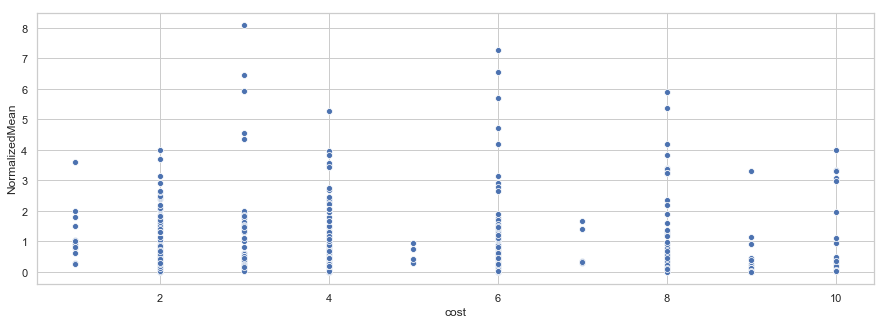

In [4]:
sns.scatterplot(data=df,x="cost",y="NormalizedMean")
plt.savefig('cost_vs_normalizedMean.png')

In [5]:
something['fwd_num_total_hits'].describe()

count      6382.000000
mean         61.740364
std        2580.733993
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max      118912.000000
Name: fwd_num_total_hits, dtype: float64

In [17]:
len(something[something['fwd_num_total_hits']<50])

6370

In [14]:
len(something)

6382